In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, isnan, when, count,min,max,lit,monotonically_increasing_id,udf
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, PCA, VectorAssembler, MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import Evaluator as evaluator
import pandas as pd
from pyspark.sql.types import *

import numpy as np

In [2]:
#creating a spark session
spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "15g") \
    .appName('Bosch Project') \
    .getOrCreate()

In [3]:
#loding the numeric data
df = spark.read.csv("train_numeric.csv", header=True, inferSchema=True)
df_test = spark.read.csv("test_numeric.csv", header=True, inferSchema=True)

df_numeric = df.select(df.columns)
labels = df.select(df.columns[-1])
labels_test = df_test.select(df_test.columns[-1])

In [4]:
#All these column names show us 
df_test.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- L0_S0_F0: double (nullable = true)
 |-- L0_S0_F2: double (nullable = true)
 |-- L0_S0_F4: double (nullable = true)
 |-- L0_S0_F6: double (nullable = true)
 |-- L0_S0_F8: double (nullable = true)
 |-- L0_S0_F10: double (nullable = true)
 |-- L0_S0_F12: double (nullable = true)
 |-- L0_S0_F14: double (nullable = true)
 |-- L0_S0_F16: double (nullable = true)
 |-- L0_S0_F18: double (nullable = true)
 |-- L0_S0_F20: double (nullable = true)
 |-- L0_S0_F22: double (nullable = true)
 |-- L0_S1_F24: double (nullable = true)
 |-- L0_S1_F28: double (nullable = true)
 |-- L0_S2_F32: double (nullable = true)
 |-- L0_S2_F36: double (nullable = true)
 |-- L0_S2_F40: double (nullable = true)
 |-- L0_S2_F44: double (nullable = true)
 |-- L0_S2_F48: double (nullable = true)
 |-- L0_S2_F52: integer (nullable = true)
 |-- L0_S2_F56: double (nullable = true)
 |-- L0_S2_F60: double (nullable = true)
 |-- L0_S2_F64: double (nullable = true)
 |-- L0_S3_F68: doubl

In [5]:
#Find the  size of the data
print("Rows", df_numeric.count())
print("Column",len(df_numeric.columns))

Rows 1183747
Column 970


In [6]:
#Find the  size of the test data
print("Rows", df_test.count())
print("Column",len(df_test.columns))

Rows 1183748
Column 969


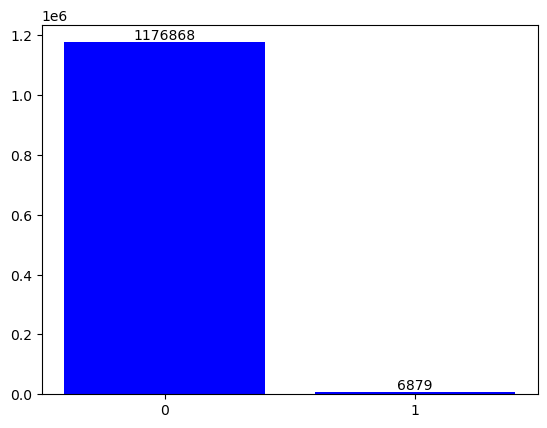

In [7]:
count_of_zeros = labels.filter(labels["Response"] == 0).count()
count_of_ones = labels.filter(labels["Response"] == 1).count()


categories = ['0','1']
bars = plt.bar(categories, [count_of_zeros,count_of_ones], color = 'blue' )
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval), ha='center', va='bottom')
plt.show()

The bar chart analysis reveals a significant imbalance in our dataset. To mitigate this issue during model training, we recognize the importance of implementing techniques designed to handle imbalanced data. This ensures that the model is trained equitably on both minority and majority classes, enhancing its ability to generalize effectively across all class distinctions.

### High Dimensionality Reduction using PCA
Given the high number of dimensions in our dataset, a crucial preprocessing step involves dimensionality reduction. To facilitate model training, we employ Principal Component Analysis (PCA) after addressing missing values by filling them with arbitrary values and standardizing the data. Following this process, we successfully reduce the feature space to 30 principal components, streamlining the dataset for improved efficiency in model training.

In [19]:
# Fill NaN values with 9999
df_numeric = df_numeric.fillna(9999)

# Assemble the feature columns into a vector
assembler = VectorAssembler(inputCols=df_numeric.columns[1:-1], outputCol="features")
assembled_data = assembler.transform(df_numeric)

# Standardize the data for PCA
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_data)  # Fit on the assembled data
scaled_data = scaler_model.transform(assembled_data)

# Perform PCA
n_components = 100
pca = PCA(k=n_components, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(scaled_data)  # Fit on the scaled data
pca_data = pca_model.transform(scaled_data)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


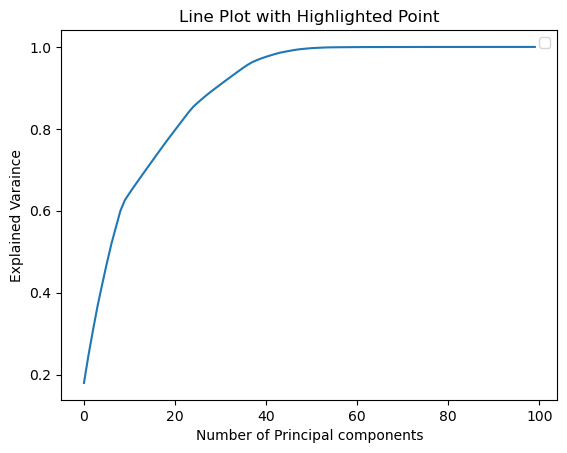

In [23]:
expVarz = np.cumsum(np.array(pca_model.explainedVariance))

plt.plot(range(len(expVarz)),expVarz)

plt.xlabel('Number of Principal components')
plt.ylabel('Explained Varaince')
plt.title('Line Plot with Highlighted Point')

plt.legend()

plt.show()

In [24]:
# Perform PCA
n_components = 30
pca = PCA(k=n_components, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(scaled_data)  # Fit on the scaled data
pca_data = pca_model.transform(scaled_data)

In [9]:
# Assuming 'pca_data' is the object returned by PCA.transform()
pca_feature = pca_data.select(["pca_features"]).collect()

In [10]:
# Convert pca_features to a NumPy array
pca_features_array = np.array(pca_feature)

# Assuming 'pca_data' is the array of PCA features
pca_data_2d = pca_features_array.reshape(1183747, 30)

# Create a Pandas DataFrame
pca_df = pd.DataFrame(pca_data_2d, columns=['PC%i' % i for i in range(n_components)])


In [11]:

pca_df['Response'] =  pca_data.select("Response").rdd.flatMap(lambda x: x).collect()


In [13]:
pca_df.to_csv("pca_transformed.csv")